In [1]:
import pandas as pd
import random
import seaborn as sns
%run infectionspread.py

In [2]:
df_traveller = pd.read_csv("..\data\penetration\TUnvacc_HomeQuar_14d_traveller_breach_timeseries.csv")
df_traveller["time_left_quarantine"] = df_traveller["t_incubation"] + df_traveller["t_post_incubation"] - df_traveller["days_infectious_community"]

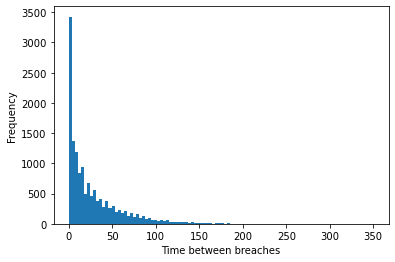

In [3]:
x=df_traveller["time_discharged"][1:].values - df_traveller["time_discharged"][0:-1].values
plt.hist(x=x, bins=100);
plt.xlabel('Time between breaches');
plt.ylabel('Frequency');

In [4]:
num_breaches = len(df_traveller)
time_period = max(df_traveller["time_discharged"])
avg_breaches = num_breaches / time_period

time_horizon = 365
breaches_over_horizon = round(avg_breaches * time_horizon)

In [38]:
def calculate_concurrent_outbreaks(transmission_potential, breaches_over_horizon, quarantine_type, quarantine_duration, df_traveller):

    breach_times = np.random.uniform(low=0, high=365, size=breaches_over_horizon)
    gen_zero_times = random.choices(df_traveller["time_left_quarantine"], k=breaches_over_horizon)
    ob = []

    for iter in range(breaches_over_horizon):
    
        ob.append(run_outbreak(num_escaped=1, max_generations=np.inf, max_infections = 20,
                               generation_zero_time_left_quarantine=(gen_zero_times[iter],),
                               transmission_potential_mean=transmission_potential, max_time=50 ) )

    results = {
    'finalsize': [get_finalsize(outbreak) for outbreak in ob],
    'breach_times': breach_times,
    'days_in_community': gen_zero_times
    }

    df = pd.DataFrame(data=results)

    df["outbreak_end_time"]=df["breach_times"]+21
    df["is_outbreak"]=df["finalsize"]>=5

    df_outbreaks = df[df.is_outbreak].sort_values(by="breach_times")
    
    max_concurrent_outbreaks = 0
    if len(df_outbreaks) > 0:
        for i in range(len(df_outbreaks)-1):
            concurrent_outbreaks = 1
            end_time = df_outbreaks["outbreak_end_time"].values[i]
            for j in range(i+1, len(df_outbreaks)):
                start_time = df_outbreaks["breach_times"].values[j]
                if start_time < end_time:
                    concurrent_outbreaks += 1
            max_concurrent_outbreaks = max(max_concurrent_outbreaks, concurrent_outbreaks)

    return ({
        'max_concurrent_outbreaks': max_concurrent_outbreaks,
        'df': df
    })

In [51]:
def concurrent_outbreak_probabilities(transmission_potential, breaches_over_horizon, quarantine_type, quarantine_duration, max_iterations=10000):
    #Data loading  block:
    filename = "..\data\penetration\TUnvacc_%s_%sd_traveller_breach_timeseries.csv" % (quarantine_type, str(quarantine_duration))
    df_traveller = pd.read_csv(filename)
    df_traveller["time_left_quarantine"] = df_traveller["t_incubation"] + df_traveller["t_post_incubation"] - df_traveller["days_infectious_community"]

    if breaches_over_horizon is None:
        num_breaches = len(df_traveller)
        time_period = max(df_traveller["time_discharged"])
        avg_breaches = num_breaches / time_period

        time_horizon = 365
        breaches_over_horizon = round(avg_breaches * time_horizon)

        print(str(breaches_over_horizon)+" breaches for TP="+str(transmission_potential))

    concurrent_outbreaks = []
    for i in range(max_iterations):
        x=calculate_concurrent_outbreaks(transmission_potential=transmission_potential, breaches_over_horizon=breaches_over_horizon, 
                                         quarantine_type=quarantine_type, quarantine_duration=quarantine_duration, df_traveller=df_traveller)
        concurrent_outbreaks.append(x["max_concurrent_outbreaks"])

    ret = pd.Series(concurrent_outbreaks).value_counts(sort=False) / max_iterations

    return (ret)

In [52]:
breaches_over_horizon = 13
max_iterations = 10000

concurrents_14d = {
    '1.2': concurrent_outbreak_probabilities(1.2, breaches_over_horizon=None, quarantine_type="HomeQuar", quarantine_duration=14),
    '1.8': concurrent_outbreak_probabilities(1.8, breaches_over_horizon=None, quarantine_type="HomeQuar", quarantine_duration=14)
}

concurrents_7d = {
    '1.2': concurrent_outbreak_probabilities(1.2, breaches_over_horizon=None, quarantine_type="HomeQuar", quarantine_duration=7),
    '1.8': concurrent_outbreak_probabilities(1.8, breaches_over_horizon=None, quarantine_type="HomeQuar", quarantine_duration=7)
}

pd.DataFrame(concurrents_14d)
pd.DataFrame(concurrents_7d)


13 breaches for TP=1.2
13 breaches for TP=1.8
28 breaches for TP=1.2
28 breaches for TP=1.8


,1.2,1.8
0,0.3206,0.1698
1,0.4643,0.4787
2,0.2004,0.3178
3,0.0143,0.0320
4,0.0004,0.0017


In [53]:
df_14d = pd.DataFrame(concurrents_14d)

df_14d["num_outbreaks"] = range(len(df_14d))
pdf_14d["quarantine_duration"] = 14


d7d = pd.DataFrame(concurrents_7d)_me
ldf_7d["num_outbreaks"] = range(len(df_7d))
df_17["quarantine_duration"] = 17
e
ddf = pd.concat((df_14d, df_7d))
 = d.melt()df, value_vars=["1.2","1.8"], value_name="outbreaks", var_name="TP", id_vars="["num_outbreaks"], ""quarantine_duration"

D:\COVIDQuarantine\python\envs\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


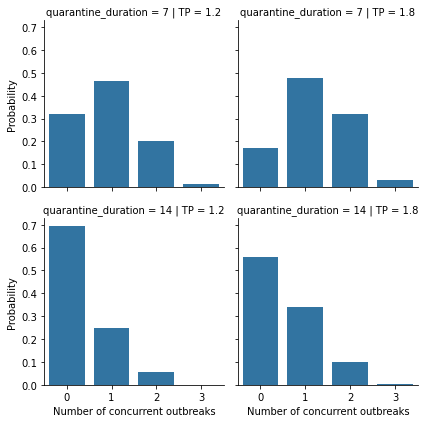

In [54]:


#sns.set_theme()
g = sns.FacetGrid(df_melted, col="TP", row="quarantine_duration")
ax = g.map(sns.barplot, "num_outbreaks","outbreaks")
ax.set_xlabels("Number of concurrent outbreaks")
ax.set_ylabels("Probability")

In [ ]:
concurrent_outbreak_probabilities(1.2)